In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import random

In [9]:
url = 'https://www.basketball-reference.com'

r = requests.get(url)
time.sleep(random.uniform(2,5))
if r.status_code == 429:
    wait_time = r.headers.get("Retry-After")
    print(f"Wait {wait_time} seconds")

soup = BeautifulSoup(r.content, 'lxml') # object that represents the html file

In [10]:
import re

teams_parsed = soup.find_all('select', {'id': 'select_team'})

list_all_teams = str(teams_parsed[0]).split('\n')[2:-1]

team_list = []
for team in list_all_teams:
    match = re.search(r'"(.*?)"', team)
    output = match.group()[1:-1]
    team_list.append(output)
    

In [11]:
team_list

['/teams/ATL',
 '/teams/BOS',
 '/teams/BRK',
 '/teams/CHI',
 '/teams/CHO',
 '/teams/CLE',
 '/teams/DAL',
 '/teams/DEN',
 '/teams/DET',
 '/teams/GSW',
 '/teams/HOU',
 '/teams/IND',
 '/teams/LAC',
 '/teams/LAL',
 '/teams/MEM',
 '/teams/MIA',
 '/teams/MIL',
 '/teams/MIN',
 '/teams/NOP',
 '/teams/NYK',
 '/teams/OKC',
 '/teams/ORL',
 '/teams/PHI',
 '/teams/PHO',
 '/teams/POR',
 '/teams/SAC',
 '/teams/SAS',
 '/teams/TOR',
 '/teams/UTA',
 '/teams/WAS']

In [12]:
def get_stats(year):
    nba_info = []
    for i in team_list:
        team_url = (f'https://www.basketball-reference.com{i}/{str(year)}.html')
        team_res = requests.get(team_url)
        time.sleep(random.uniform(2,5))
        team_soup = BeautifulSoup(team_res.content, 'lxml')
        per_game = team_soup.find(name = 'table', attrs={'id': 'per_game_stats'})
        for row in per_game.find_all('tr')[1:-1]:
            player = {}
            player['Name'] = row.find('td', {'data-stat': 'name_display'}).text
            team = i[-3:]
            player['Team'] = team
            player['Age'] = row.find('td', {'data-stat' : 'age'}).text
            player['Min PG'] = row.find('td', {'data-stat' : 'mp_per_g'}).text
            player['Field Goal %'] = row.find('td', {'data-stat' : 'fg_pct'}).text
            player['Rebounds PG'] = row.find('td', {'data-stat' : 'trb_per_g'}).text
            player['Assists PG'] = row.find('td', {'data-stat' : 'ast_per_g'}).text
            player['Steals PG'] = row.find('td', {'data-stat' : 'stl_per_g'}).text
            player['Blocks PG'] = row.find('td', {'data-stat' : 'blk_per_g'}).text
            player['Turnovers PG'] = row.find('td', {'data-stat' : 'tov_per_g'}).text
            player['Points PG'] = row.find('td', {'data-stat' : 'pts_per_g'}).text

            name_td = row.find('td', {'data-stat': 'name_display'})
            a_tag = name_td.find('a')['href']
            player_url = 'https://www.basketball-reference.com' + a_tag
            player_request = requests.get(player_url)
            time.sleep(random.uniform(2,5))
            player_soup = BeautifulSoup(player_request.content, 'lxml')
            player_info = player_soup.find(name = 'div', attrs = {'id' : 'info', 'class' : 'players'})

            player_links = []
            for link in player_info.find_all('a'):
                player_links.append(link.get('href'))
            if 'instagram' in player_links[0]:
                player['Insta Handle'] = player_links[0].replace('https://instagram.com/', '')
            else:
                player['Insta Handle'] = 'N/A'
            
            position_tag = player_info.find('strong', string=lambda text: text and 'Position' in text)
            position = ' '.join(position_tag.next_sibling.text.strip().split()[:-1])
            player['Position'] = position
            p_tag = position_tag.find_parent('p').find_next_sibling()
            spans = p_tag.find_all('span')
            height, weight = spans[0].text, spans[1].text
            player['Height'] = height
            player['Weight (lbs)'] = weight[:-2]

            nba_info.append(player)
        
    nba_info_df = pd.DataFrame(nba_info)
    return nba_info_df
            



In [13]:
all_nba_players_2025 = get_stats(2025)
all_nba_players_2025

,Name,Team,Age,Min PG,Field Goal %,Rebounds PG,Assists PG,Steals PG,Blocks PG,Turnovers PG,Points PG,Insta Handle,Position,Height,Weight (lbs)
0,Trae Young,ATL,26,36.0,.411,3.1,11.6,1.2,0.2,4.7,24.2,traeyoung,Point Guard,6-1,164
1,Jalen Johnson,ATL,23,35.7,.500,10.0,5.0,1.6,1.0,2.9,18.9,jalenjohnson,Small Forward and Power Forward,6-9,220
2,Dyson Daniels,ATL,21,33.8,.493,5.9,4.4,3.0,0.7,2.0,14.1,dysondanielss11,Point Guard and Shooting Guard,6-8,199
3,De'Andre Hunter,ATL,27,28.8,.461,3.9,1.5,0.8,0.1,1.6,19.0,N/A,Small Forward,6-8,225
4,Onyeka Okongwu,ATL,24,27.9,.567,8.9,2.3,0.9,0.9,1.2,13.4,big0,Center,6-8,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,Marvin Bagley III,WAS,25,8.7,.535,2.9,0.4,0.4,0.3,0.6,4.9,mb3five,Center and Power Forward,6-10,235
650,Anthony Gill,WAS,32,7.8,.489,1.3,0.3,0.2,0.0,0.2,2.5,anthonygill.13,Power Forward,6-7,230
651,Johnny Davis,WAS,22,7.1,.410,1.1,0.3,0.4,0.2,0.2,2.4,johnnydavis,Shooting Guard,6-5,196
652,Patrick Baldwin Jr.,WAS,22,4.6,.515,1.0,0.1,0.1,0.1,0.2,2.1,patrick.baldwin.jr,Small Forward,6-9,220


In [14]:
def toNum(nba_df):
    str_cols = ['Name', 'Team', 'Insta Handle', 'Position', 'Height']
    for i in nba_df.columns:
        if i not in str_cols:
            nba_df[i] = pd.to_numeric(nba_df[i])
    print(nba_df.dtypes)

toNum(all_nba_players_2025)

Name             object
Team             object
Age               int64
Min PG          float64
Field Goal %    float64
Rebounds PG     float64
Assists PG      float64
Steals PG       float64
Blocks PG       float64
Turnovers PG    float64
Points PG       float64
Insta Handle     object
Position         object
Height           object
Weight (lbs)      int64
dtype: object


Filters to see all the Miami Heat players whose field goal percentage is at or below 40%

In [19]:
all_nba_players_2025.query("Team == 'MIA' and `Field Goal %` <= 0.4")


,Name,Team,Age,Min PG,Field Goal %,Rebounds PG,Assists PG,Steals PG,Blocks PG,Turnovers PG,Points PG,Insta Handle,Position,Height,Weight (lbs)
331,Terry Rozier,MIA,30,25.9,0.391,3.7,2.6,0.6,0.2,1.2,10.6,N/A,Point Guard and Shooting Guard,6-1,190
338,Josh Richardson,MIA,31,18.8,0.289,1.5,1.5,1.0,0.1,1.0,4.0,jrich_0,Shooting Guard and Small Forward,6-5,200
343,Kevin Love,MIA,36,10.9,0.357,4.1,1.0,0.7,0.2,0.6,5.3,kevinlove,Power Forward and Center,6-8,251
345,Josh Christopher,MIA,23,4.9,0.355,0.6,0.6,0.4,0.2,0.4,2.0,jaygup,Shooting Guard,6-5,215
346,Isaiah Stevens,MIA,24,2.0,0.000,0.7,0.0,0.3,0.0,0.0,0.0,isaiahstevens4,Point Guard,6-0,185


This find the top ten lightest (weight) NBA teams

In [16]:
all_nba_players_2025.groupby('Team')[['Weight (lbs)']].sum().sort_values(by='Weight (lbs)', ascending=True).head(10)

,Weight (lbs)
Team,
ORL,3684
DEN,3820
BOS,3913
HOU,3973
POR,4064
OKC,4089
MIN,4253
UTA,4351
PHO,4361


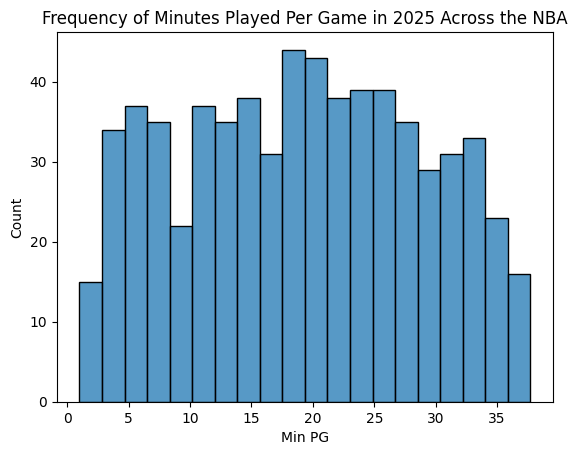

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(all_nba_players_2025['Min PG'], bins=20)
plt.title('Frequency of Minutes Played Per Game in 2025 Across the NBA');

In [22]:
%pip install seaborn
%pip install matplotlib

  Using cached matplotlib-3.10.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.3.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (322 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 26.7 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Using cached 

Text(0.5, 1.0, 'Relationship Between Average Minutes Played and Turnovers Per Game')

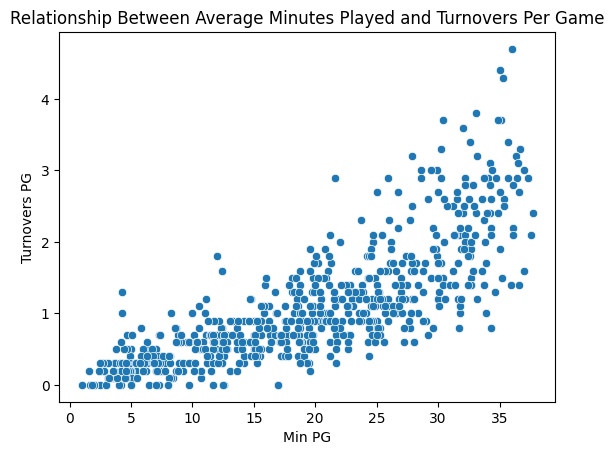

In [26]:
sns.scatterplot(x=all_nba_players_2021['Min PG'], y=all_nba_players_2021['Turnovers PG'])
plt.title('Relationship Between Average Minutes Played and Turnovers Per Game')